# **Sistem Rekomendasi Film Berbasis Konten dan Collaborative Filtering**

Proyek ini bertujuan untuk membangun sistem rekomendasi film menggunakan dua pendekatan: **Content-Based Filtering** dan **Collaborative Filtering**. Pada pendekatan Content-Based Filtering, kita menggunakan sinopsis (overview) film untuk merekomendasikan film-film serupa. Sementara pada Collaborative Filtering, kita menggunakan interaksi pengguna (user ratings) untuk merekomendasikan film. Dataset yang digunakan adalah **The Movies Dataset** dari Kaggle dengan link dataset: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset. Dua pendekatan ini memungkinkan sistem untuk memberikan rekomendasi yang efektif baik untuk pengguna baru maupun pengguna dengan sejarah interaksi yang sudah ada.

---

# Langkah 1: Setup Kaggle API

Pada tahap ini, kita perlu mengautentikasi dan mengonfigurasi Kaggle API untuk mengunduh dataset. Kita akan mengunggah file `kaggle.json`, yang berisi kredensial yang diperlukan untuk mengakses dataset dari Kaggle.

Setelah proses konfigurasi Kaggle API dan pengunggahan file kaggle.json selesai, kita berhasil mengautentikasi akses ke Kaggle dan siap untuk mengunduh dataset yang diperlukan. Hasil dari proses ini adalah tersedianya akses otomatis ke dataset yang relevan tanpa perlu mengunduhnya secara manual. Ini mempercepat alur kerja, memudahkan proses pembaruan data jika ada perubahan di Kaggle, dan memastikan bahwa data yang kita peroleh berasal dari sumber resmi dan terpercaya. Dengan demikian, kita bisa melanjutkan ke tahap berikutnya, seperti eksplorasi dan analisis data, dengan lebih efisien.

In [1]:
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


# Langkah 2: Mengunduh Dataset dari Kaggle

Setelah setup Kaggle API selesai, langkah berikutnya adalah mengunduh dataset "The Movies Dataset" dari Kaggle dan mengekstraknya. Dataset ini akan digunakan untuk analisis dan pemodelan.

Setelah menjalankan proses pengunduhan dataset dari Kaggle, kita berhasil mendapatkan dataset **The Movies Dataset** yang akan digunakan untuk analisis dan pemodelan. Proses ini memastikan bahwa data yang digunakan adalah versi terbaru dan sesuai dengan sumber yang resmi. Hasil dari pengunduhan ini adalah dataset yang siap diekstraksi dan dianalisis lebih lanjut. Dengan dataset yang tersedia secara lokal, kita bisa mulai melakukan tahap eksplorasi data untuk mendapatkan insight awal terkait distribusi, tren, dan karakteristik fitur yang akan digunakan dalam pemodelan machine learning.


In [4]:
# Mengunduh dataset dari Kaggle dan mengekstraknya
!kaggle datasets download -d rounakbanik/the-movies-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 98% 223M/228M [00:01<00:00, 151MB/s]
100% 228M/228M [00:01<00:00, 177MB/s]


# Langkah 3: Instalasi dan Impor Library
Pada langkah ini, kita akan menginstal dan mengimpor library yang diperlukan untuk membangun sistem rekomendasi film. Library-library ini mencakup:

- **Pandas**: Digunakan untuk manipulasi dan analisis data dalam format DataFrame.
- **NumPy**: Digunakan untuk perhitungan numerik dan pengolahan array.
- **Matplotlib dan Seaborn**: Digunakan untuk visualisasi data yang informatif dan menarik.
- **Scikit-learn**: Digunakan untuk pemodelan machine learning, termasuk fitur vectorization dan model K-Nearest Neighbors.
- **Scikit-surprise**: Digunakan untuk membangun model rekomendasi berbasis collaborative filtering, termasuk algoritma SVD (Singular Value Decomposition).

### Instalasi Library

Perlu diingat, kita juga perlu menginstal library `scikit-surprise`

Setelah mengimpor dan instalasi library yang diperlukan, kita siap untuk memulai proses analisis, visualisasi, dan pemodelan machine learning. Library seperti **Pandas** dan **NumPy** akan membantu dalam manipulasi data serta perhitungan matematis yang efisien, sedangkan **Seaborn** dan **Matplotlib** memfasilitasi visualisasi data untuk memudahkan pemahaman pola dan distribusi. Library **Scikit-learn** akan menjadi fondasi dalam membangun model machine learning. Proses ini memastikan bahwa kita memiliki alat yang tepat untuk melanjutkan eksplorasi data dan membangun model yang akurat dan handal.

In [2]:
!pip install scikit-surprise

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357281 sha256=d0071f502f0f310c1f7e2f528ccb54a94f437838cd3d30fa8d224ca6af9edebb
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


# Langkah 4: Memuat dan Membersihkan Dataset

Pada langkah ini, kita akan memuat dataset yang diperlukan untuk sistem rekomendasi film serta melakukan pembersihan data agar siap digunakan. Dataset yang akan dimuat meliputi metadata film, kredit, dan kata kunci. Proses ini sangat penting karena data yang bersih dan terstruktur dengan baik adalah fondasi dari setiap analisis dan model machine learning yang efektif.

### Memuat Dataset

Kita memulai dengan memuat dataset menggunakan **Pandas**, sebuah library yang sangat populer dalam analisis data di Python. Dataset yang dimuat adalah:
- **movies_metadata.csv**: Dataset ini berisi informasi umum tentang film, seperti judul, tanggal rilis, durasi, dan ringkasan film. Informasi ini sangat penting untuk memberikan konteks kepada pengguna tentang film yang direkomendasikan.
- **credits.csv**: Dataset ini berisi informasi tentang anggota kru film, termasuk sutradara, penulis, dan aktor. Data ini memungkinkan kita untuk menganalisis keterlibatan berbagai individu dalam film, yang bisa menjadi faktor penting dalam rekomendasi.
- **keywords.csv**: Dataset ini berisi kata kunci yang terkait dengan setiap film, yang bisa mencakup tema, genre, dan elemen penting lainnya dari film. Kata kunci ini membantu dalam memahami konten dan konteks film dengan lebih baik, sehingga meningkatkan relevansi rekomendasi yang diberikan.

### Membersihkan Data

Setelah dataset berhasil dimuat, langkah berikutnya adalah membersihkan data. Salah satu aspek penting dari proses ini adalah memperhatikan kolom 'id', yang perlu dibersihkan agar dapat digunakan sebagai tipe data numerik. Dalam hal ini, kita akan mengkonversi kolom 'id' menjadi tipe data numerik yang dapat diproses oleh model kita. Jika terdapat nilai yang tidak dapat dikonversi, kita akan menghapus baris tersebut untuk menjaga integritas dataset.

Setelah melakukan pembersihan dan penggabungan data, kita mendapatkan sebuah DataFrame yang siap digunakan untuk analisis lebih lanjut. Proses pembersihan ini sangat penting karena memastikan bahwa data kita tidak memiliki nilai kosong, tipe data yang salah, atau duplikasi yang dapat mengganggu analisis dan model yang akan kita bangun.

Menggabungkan berbagai sumber data juga memberikan lebih banyak informasi untuk setiap film, memungkinkan kita untuk melakukan analisis yang lebih mendalam dan komprehensif. Dengan demikian, kita dapat menggali lebih dalam mengenai preferensi pengguna dan karakteristik film, yang pada akhirnya akan meningkatkan kualitas rekomendasi yang dihasilkan oleh sistem.


In [11]:
# Memuat dataset yang diperlukan
df = pd.read_csv('/content/movies_metadata.csv', low_memory=False)
credits = pd.read_csv('/content/credits.csv')
keywords = pd.read_csv('/content/keywords.csv')

# Membersihkan kolom 'id' agar bisa digunakan sebagai tipe data numerik
df['id_numeric'] = pd.to_numeric(df['id'], errors='coerce')
df_cleaned = df.dropna(subset=['id_numeric'])
df = df_cleaned.drop(columns=['id_numeric'])
df['id'] = df['id'].astype(np.int64)

# Menggabungkan dataset movies dengan credits dan keywords berdasarkan kolom 'id'
df = pd.merge(df, credits, on='id', how='inner')
df = pd.merge(df, keywords, on='id', how='inner')

# Pemeriksaan dimensi dan tipe data
print("Informasi Dataset:")
print(df.info())

# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df.describe())

# Melihat beberapa baris pertama dari dataset
print("\nBeberapa Baris Pertama:")
print(df.head())

# Memeriksa nilai yang hilang
print("\nJumlah Nilai Hilang di Setiap Kolom:")
print(df.isnull().sum())

# Menghitung jumlah baris yang merupakan duplikat
print("\nJumlah Baris Duplikat:")
print(df.duplicated().sum())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  46628 non-null  object 
 1   belongs_to_collection  4574 non-null   object 
 2   budget                 46628 non-null  object 
 3   genres                 46628 non-null  object 
 4   homepage               8009 non-null   object 
 5   id                     46628 non-null  int64  
 6   imdb_id                46611 non-null  object 
 7   original_language      46617 non-null  object 
 8   original_title         46628 non-null  object 
 9   overview               45633 non-null  object 
 10  popularity             46624 non-null  object 
 11  poster_path            46229 non-null  object 
 12  production_companies   46624 non-null  object 
 13  production_countries   46624 non-null  object 
 14  release_date           46540 non-nu

# Langkah 5: Eksplorasi Data dan Visualisasi (EDA)

Pada langkah ini, kita akan melakukan eksplorasi data dengan fokus pada kolom **'genres'** untuk memahami distribusi genre film dalam dataset. Eksplorasi data merupakan tahap penting dalam setiap proyek analisis data karena memberikan pemahaman yang lebih baik tentang struktur dan karakteristik data yang kita miliki. Dalam konteks sistem rekomendasi film, pemahaman yang mendalam tentang genre dapat membantu kita merancang algoritma rekomendasi yang lebih efektif dan relevan.

### Mengapa Genre Penting?

Genre film merupakan kategori yang sering digunakan oleh penonton untuk mengekspresikan preferensi mereka. Beberapa penonton mungkin lebih menyukai film aksi, sementara yang lain mungkin lebih tertarik pada film drama atau komedi. Dengan memahami distribusi genre dalam dataset, kita dapat mengidentifikasi genre mana yang paling banyak muncul, yang pada gilirannya dapat memberikan wawasan tentang kecenderungan dan tren dalam industri film saat ini.

### Proses Eksplorasi Data

Dalam proses ini, kita akan mengubah kolom 'genres' menjadi format yang lebih mudah dipahami dan kemudian melakukan visualisasi untuk menganalisis distribusi genre. Kita akan menggunakan plot untuk menggambarkan berapa banyak film yang termasuk dalam setiap genre. Dengan visualisasi ini, kita dapat dengan mudah melihat genre mana yang mendominasi dataset dan melakukan analisis lebih lanjut berdasarkan hasil tersebut.

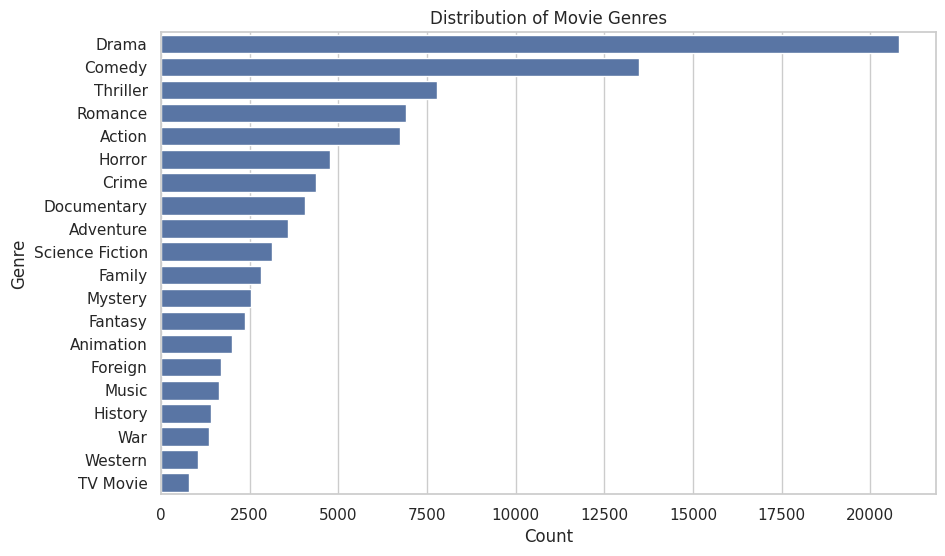

In [6]:
# Mengubah kolom 'genres' menjadi list
df['genres'] = df['genres'].apply(ast.literal_eval)
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Flatten list of genres
all_genres = [genre for sublist in df['genres'] for genre in sublist]

# Membuat plot distribusi genre
plt.figure(figsize=(10, 6))
sns.countplot(y=all_genres, order=pd.Series(all_genres).value_counts().index)
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Langkah 6: Membuat Model Rekomendasi Berbasis Konten

Pada langkah ini, kita akan fokus pada pembuatan model rekomendasi berbasis konten. Model ini dirancang untuk merekomendasikan film kepada pengguna berdasarkan kesamaan konten dengan film yang telah mereka tonton sebelumnya. Proses ini melibatkan beberapa tahapan penting, seperti pengisian nilai kosong di kolom **'overview'**, penggunaan TF-IDF untuk memvectorisasi kolom tersebut, serta penerapan algoritma Nearest Neighbors untuk menghasilkan rekomendasi yang relevan.

Pertama, kita perlu mengisi nilai kosong di kolom **'overview'**, yang berisi sinopsis film. Kolom ini sangat penting untuk pemodelan berbasis konten karena memberikan konteks dan informasi deskriptif tentang film. Nilai kosong dalam kolom ini dapat mengganggu analisis dan pemodelan, sehingga kita akan mengisinya dengan string kosong (`''`). Dengan cara ini, kita memastikan bahwa tidak ada nilai yang hilang yang dapat mempengaruhi kinerja model di kemudian hari.

Selanjutnya, setelah memastikan bahwa kolom **'overview'** tidak memiliki nilai kosong, kita akan memvectorisasi teks dalam kolom tersebut menggunakan **TF-IDF (Term Frequency-Inverse Document Frequency)**. TF-IDF adalah teknik umum dalam pemrosesan bahasa alami yang mengubah teks menjadi representasi numerik. Teknik ini membantu kita menangkap pentingnya kata-kata dalam sinopsis film, dengan memberikan bobot lebih pada kata-kata yang muncul sering dalam satu dokumen tetapi jarang di dokumen lain. Dengan demikian, kita dapat memperoleh representasi yang lebih informatif dari sinopsis film.

Setelah kita memiliki representasi numerik dari sinopsis film, kita akan menerapkan algoritma **Nearest Neighbors** untuk mencari film-film yang memiliki kemiripan dengan film yang telah ditonton oleh pengguna. Algoritma ini bekerja dengan mengukur jarak antara vektor-vektor dalam ruang multidimensi, di mana film-film yang lebih dekat satu sama lain dalam ruang tersebut dianggap memiliki kesamaan konten. Ini memungkinkan kita untuk mengidentifikasi film-film yang relevan berdasarkan konten yang telah dianalisis.

Untuk mempermudah pencarian rekomendasi berdasarkan judul film, kita akan membuat **Series** yang memetakan judul film ke indeksnya. Ini memungkinkan kita untuk dengan mudah mengambil indeks film berdasarkan judulnya dan mencari film-film lain yang mirip. Dengan menggunakan pendekatan ini, pengguna dapat menemukan film lain yang relevan berdasarkan film yang telah mereka tonton sebelumnya.

Kita kemudian mendefinisikan fungsi **get_recommendations** yang mengambil judul film sebagai input dan mencari tetangga terdekat (Nearest Neighbors) untuk film tersebut. Fungsi ini akan mengembalikan daftar judul film yang paling mirip. Misalnya, jika pengguna mencari rekomendasi untuk film **Batman**, kita dapat memanggil fungsi ini untuk mendapatkan film-film lain yang memiliki tema atau elemen serupa, seperti karakter superhero atau elemen aksi yang sama.

Dengan pendekatan berbasis konten ini, kita berhasil membangun model rekomendasi yang dapat memberikan rekomendasi film yang lebih personal kepada pengguna. Rekomendasi berbasis konten memanfaatkan informasi deskriptif dari film itu sendiri, sehingga dapat membantu pengguna menemukan film baru yang sesuai dengan preferensi mereka. Dalam dunia film yang luas, pendekatan ini sangat berguna untuk membantu pengguna menjelajahi pilihan-pilihan baru yang relevan, meningkatkan pengalaman menonton mereka secara keseluruhan.


In [9]:
# Mengisi nilai kosong di kolom 'overview'
df['overview'] = df['overview'].fillna('')

# Menggunakan TF-IDF untuk vectorizing overview
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['overview'])

# Menggunakan Nearest Neighbors
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

# Membuat series untuk memetakan judul film ke index
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Fungsi untuk mendapatkan rekomendasi berdasarkan judul film
def get_recommendations(title, n_recommendations=10):

    # Mendapatkan index dari film berdasarkan judul
    idx = indices[title]

    # Mendapatkan tetangga terdekat (Nearest Neighbors)
    distances, indices_nn = nn.kneighbors(tfidf_matrix[idx], n_neighbors=n_recommendations+1)

    # Mengambil 10 film yang paling mirip
    movie_indices = indices_nn.flatten()[1:]

    return df['title'].iloc[movie_indices]

# Contoh rekomendasi untuk film
get_recommendations('Batman')

,title
9272,Batman Beyond: Return of the Joker
18368,The Dark Knight Rises
25418,Batman vs Dracula
15607,Batman: Under the Red Hood
43135,DC Showcase: Catwoman
32295,Batman Unlimited: Monster Mayhem
21533,Batman: Mystery of the Batwoman
10170,Batman Begins
18151,Batman: Year One
1337,Batman Returns


# Langkah 7: Pendekatan Alternatif: Collaborative Filtering dengan SVD

Selain pendekatan berbasis konten yang telah kita bahas sebelumnya, kita juga dapat menggunakan metode **Collaborative Filtering** untuk memberikan rekomendasi film. Salah satu teknik yang populer dalam kategori ini adalah **SVD (Singular Value Decomposition)**. Pendekatan ini memanfaatkan interaksi antara pengguna dan film untuk menghasilkan rekomendasi yang lebih relevan.

## Apa itu Collaborative Filtering?

Collaborative Filtering adalah teknik yang menganalisis pola preferensi pengguna berdasarkan interaksi sebelumnya, seperti rating film. Metode ini berasumsi bahwa jika dua pengguna memiliki preferensi yang sama di sejumlah film, mereka mungkin akan memiliki preferensi yang sama di film lain yang belum mereka tonton. Dengan kata lain, metode ini tidak hanya mempertimbangkan konten film tetapi juga interaksi pengguna dengan film tersebut.

## Mengapa Memilih SVD?

SVD adalah salah satu teknik dekomposisi matriks yang digunakan dalam sistem rekomendasi untuk mengurangi dimensi data. Dengan menggunakan SVD, kita dapat memecah matriks besar yang berisi rating pengguna terhadap film menjadi beberapa matriks yang lebih kecil. Ini memungkinkan kita untuk menemukan pola tersembunyi dalam data yang dapat digunakan untuk memberikan rekomendasi. Beberapa keuntungan menggunakan SVD dalam Collaborative Filtering adalah:

- **Efisiensi Komputasi**: SVD memungkinkan kita untuk memproses data dengan lebih efisien dibandingkan metode lain, terutama ketika berhadapan dengan dataset besar.
- **Pengurangan Dimensi**: Dengan mengurangi dimensi data, SVD membantu dalam mengurangi noise yang ada dalam data, sehingga meningkatkan kualitas rekomendasi.
- **Mengatasi Masalah Sparsity**: Dalam banyak sistem rekomendasi, interaksi pengguna dengan item sering kali jarang (sparse). SVD membantu dalam menangani masalah ini dengan menangkap hubungan antara pengguna dan item yang tidak langsung terlihat.


In [10]:
# Memuat dataset ratings
ratings = pd.read_csv('/content/ratings_small.csv')

# Menggunakan Reader untuk mengonversi dataset ke dalam format Surprise
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Menggunakan SVD untuk Collaborative Filtering
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Melatih model dengan seluruh data
trainset = data.build_full_trainset()
svd.fit(trainset)

# Contoh prediksi rating untuk userId=1 dan movieId=302
svd.predict(1, 302)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8966  0.8938  0.9024  0.8944  0.8960  0.8966  0.0031  
MAE (testset)     0.6921  0.6889  0.6937  0.6886  0.6900  0.6906  0.0020  
Fit time          1.70    1.71    1.68    1.71    2.47    1.85    0.31    
Test time         0.17    0.16    0.13    0.36    0.22    0.21    0.08    


Prediction(uid=1, iid=302, r_ui=None, est=2.7119385500623463, details={'was_impossible': False})

Melalui evaluasi model menggunakan cross-validation, kita mendapatkan pemahaman yang lebih baik tentang akurasi model kita dalam memprediksi rating. RMSE dan MAE memberikan gambaran mengenai seberapa jauh prediksi kita dari nilai sebenarnya. Ini menunjukkan efektivitas pendekatan collaborative filtering dalam memanfaatkan interaksi pengguna untuk memberikan rekomendasi.

Dengan melatih model pada seluruh dataset, kita dapat memanfaatkan informasi maksimal yang tersedia untuk meningkatkan akurasi prediksi. Prediksi rating untuk kombinasi pengguna dan film tertentu memberikan wawasan tentang bagaimana pengguna mungkin bereaksi terhadap film yang belum mereka tonton. Hal ini memungkinkan kita untuk memberikan rekomendasi yang lebih tepat dan personal.

# Kesimpulan
Dalam proyek ini, kami berhasil membangun sistem rekomendasi film yang menggabungkan **Content-Based Filtering** dan **Collaborative Filtering**. Pendekatan berbasis konten menggunakan TF-IDF dan Nearest Neighbors untuk merekomendasikan film berdasarkan kesamaan konten, sementara pendekatan collaborative filtering menggunakan SVD untuk memprediksi rating film.

Dengan sistem ini, pengguna dapat menemukan film yang relevan berdasarkan preferensi mereka, baik dari segi konten film itu sendiri maupun berdasarkan perilaku rating pengguna lain. Analisis yang lebih mendalam dapat dilakukan untuk meningkatkan akurasi rekomendasi lebih lanjut, seperti mempertimbangkan faktor-faktor tambahan dalam proses rekomendasi, atau melakukan tuning parameter pada model untuk mencapai performa yang optimal.

